Sample of generated A/B test data:
  user_id      group  converted  revenue  age  days_since_registration  \
0  user_0  treatment          0      0.0   47                      148   
1  user_1    control          0      0.0   63                      221   
2  user_2    control          0      0.0   43                      186   
3  user_3    control          0      0.0   62                      355   
4  user_4    control          0      0.0   31                      336   

   past_visit_count experiment_start_date  pre_experiment_converted  \
0                 5            2023-01-11                         0   
1                 5            2023-01-02                         0   
2                 4            2023-01-09                         0   
3                 4            2023-01-19                         1   
4                 2            2023-01-19                         0   

   pre_experiment_revenue  
0                0.000000  
1                0.000000  
2        

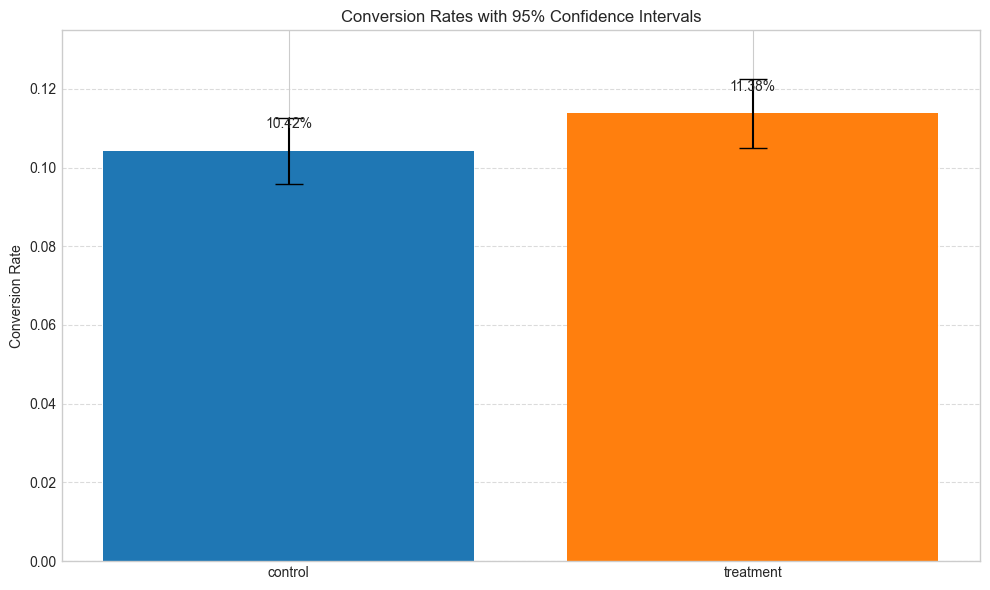

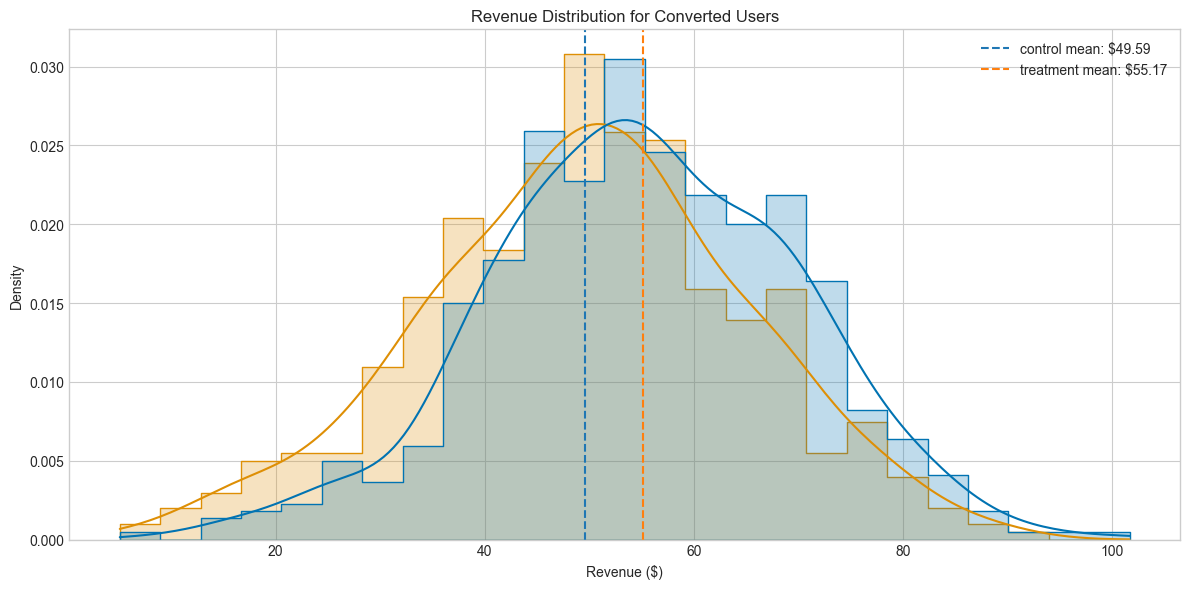

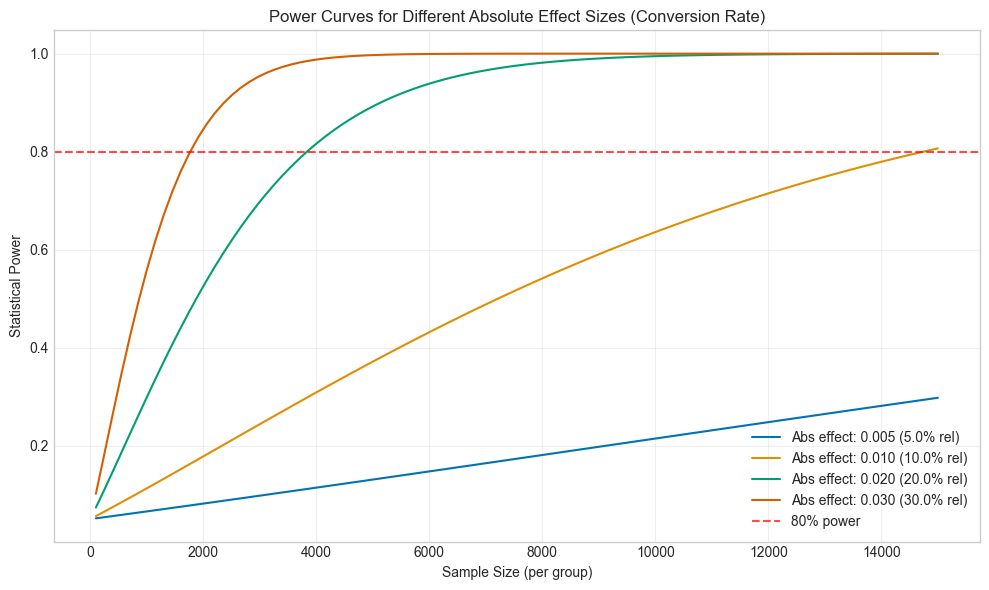


BAYESIAN A/B TEST RESULTS (Conversion Rate)

Probability Treatment > Control: 93.69%
Expected Absolute Difference: 0.0096
95% Credible Interval for Difference: (-0.0027, 0.0218)
Expected Relative Lift: 9.40%
95% Credible Interval for Relative Lift: (-2.42%, 22.08%)

Posterior Parameters:
  Control: Beta(alpha=522, beta=4480)
  Treatment: Beta(alpha=570, beta=4432)



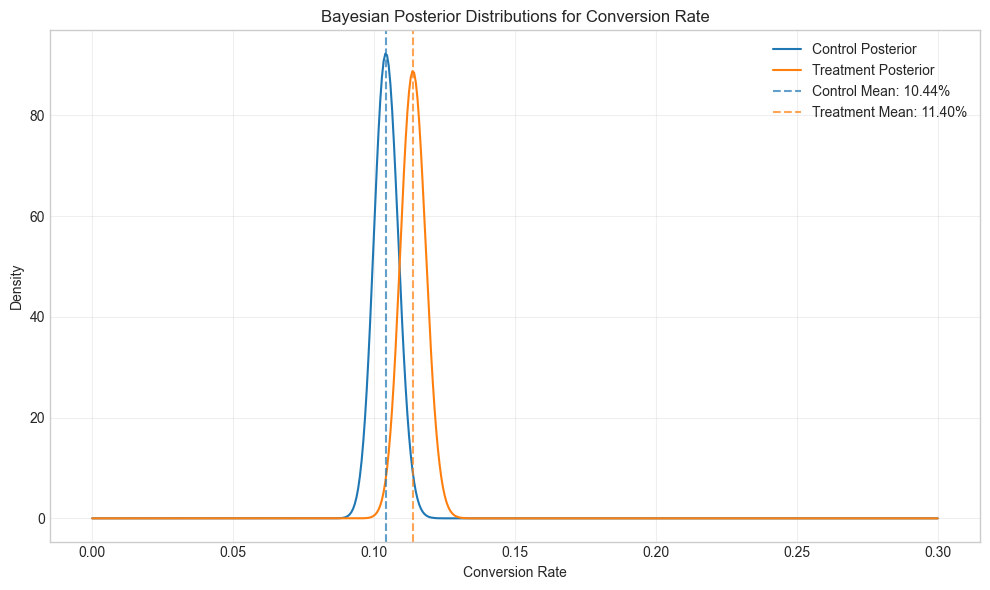


Sample of generated MVT data:
  user_id group  converted    revenue
0     A_0     A          0   0.000000
1     A_1     A          0   0.000000
2     A_2     A          0   0.000000
3     A_3     A          0   0.000000
4     A_4     A          1  80.663903

Basic statistics by group (MVT):
      converted             revenue           
          count      mean      mean        std
group                                         
A          3000  0.085333  4.234933  14.582245
B          3000  0.111667  5.749963  16.840353
C          3000  0.126000  7.273939  19.876874
D          3000  0.105667  5.617988  17.078199

MULTIVARIATE TESTING (MVT) RESULTS

1. CONVERSION RATE ANALYSIS (Chi-squared Test)
Contingency Table:
converted     0    1
group               
A          2744  256
B          2665  335
C          2622  378
D          2683  317

Chi-squared Statistic: 26.7727
P-value: 0.0000
Statistically Significant (alpha=0.05): Yes

Pairwise Z-Tests (Bonferroni Correction):
  pairwise_pro

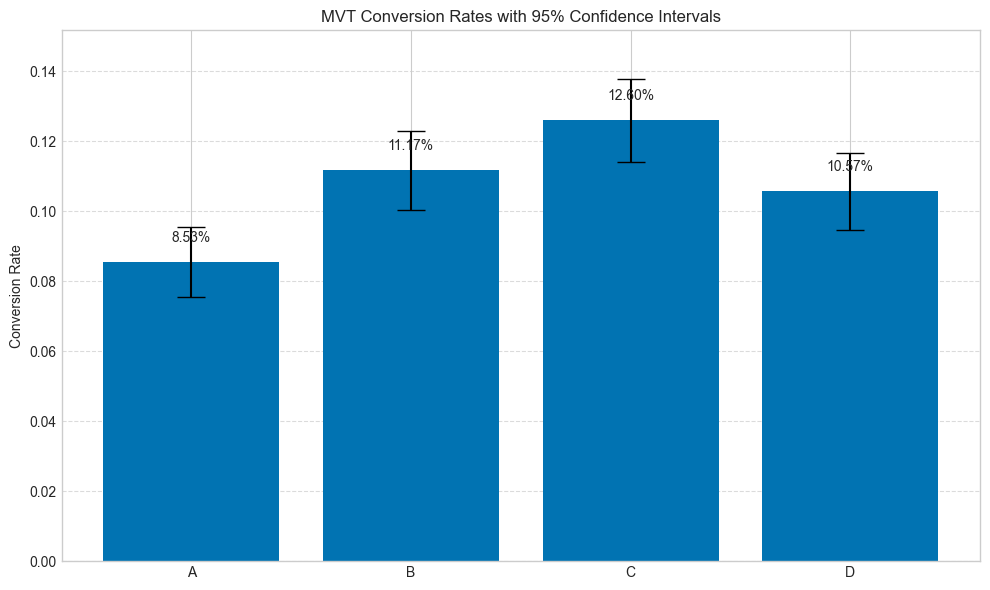

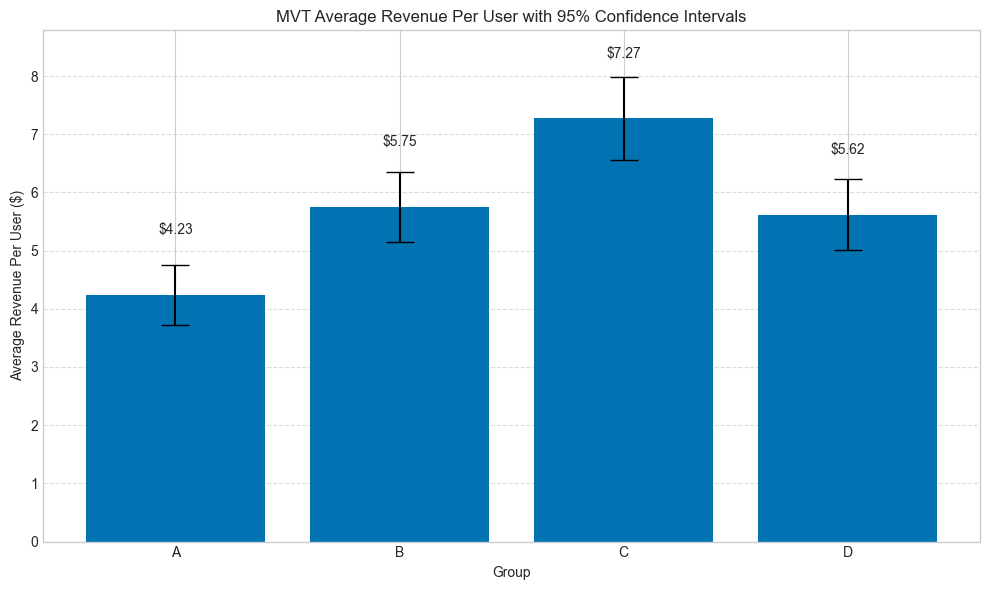


CUPED Calculation:
  Theta (covariance(Y, X) / variance(X) from control group): 0.0003
  CUPED adjusted metric added as 'cuped_adjusted_metric'

CUPED (Controlled-experiment Using Pre-Experiment Data) RESULTS

Analysis on CUPED Adjusted Metric:
  Control Mean (Adjusted): $5.17
  Treatment Mean (Adjusted): $6.28
  Absolute Difference (Adjusted): $1.11
  Relative Lift (based on original control mean): 21.51%
  T-Statistic: -3.2469
  P-value: 0.0012
  Statistically Significant (alpha=0.05): Yes

Variance Comparison:
  Control Original Variance: 254.48
  Control Adjusted Variance: 254.48
  Control Variance Reduction: 0.00%
  Treatment Original Variance: 331.37
  Treatment Adjusted Variance: 331.37
  Treatment Variance Reduction: 0.00%



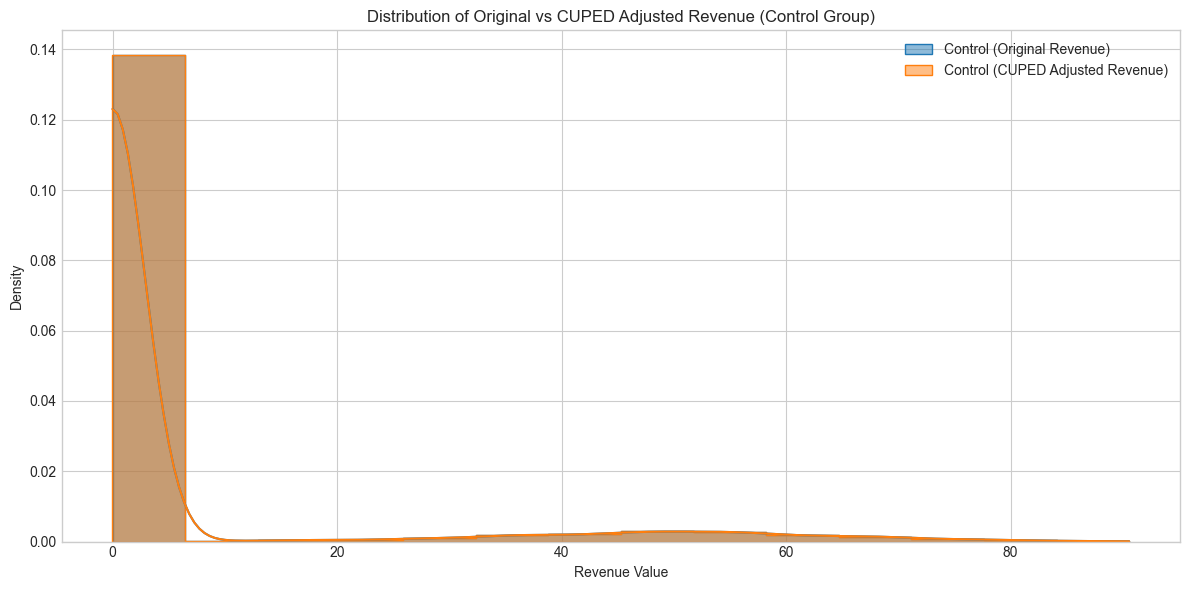


SPRT Parameters:
  Alpha (Type I Error): 0.05
  Beta (Type II Error): 0.20
  Null Hypothesis (p0): 10.00%
  Alternative Hypothesis (p1): 12.00%
  Accept H0 Boundary (A): -1.5581
  Boundary B (Accept H1): 2.7726
  Total sample size: 10000

Running SPRT simulation...
SPRT Simulation finished. Decision: Stop: Accept H1 (Treatment is significantly better than Control)

SEQUENTIAL PROBABILITY RATIO TEST (SPRT) RESULTS
Decision: Stop: Accept H1 (Treatment is significantly better than Control)
Sample Size at Decision: 1004
Final LLR: 2.8494
Boundary A (Accept H0): -1.5581
Boundary B (Accept H1): 2.7726


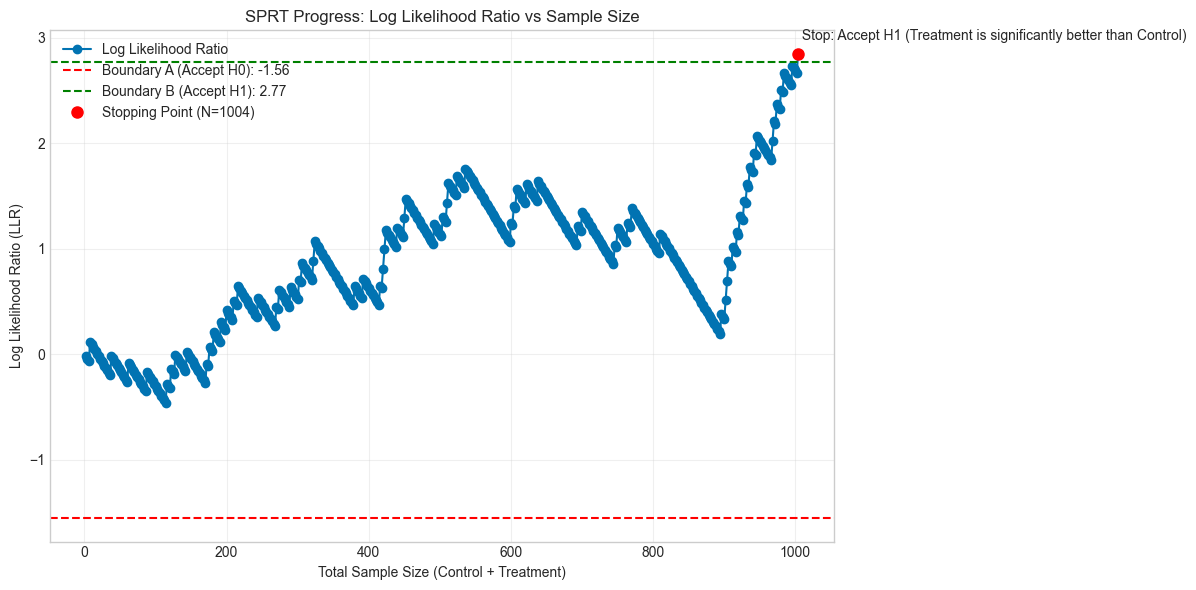

In [18]:
"""
Comprehensive A/B Testing in Python
----------------------------------
This script demonstrates various approaches to A/B testing and results analysis including:
1. Basic A/B testing with frequentist methods
2. Bayesian A/B testing
3. Multivariate testing
4. CUPED (Controlled-experiment Using Pre-Experiment Data)
5. Sequential Probability Ratio Test (SPRT)

Each section includes appropriate visualizations and statistical analysis.
"""

import warnings

warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)




import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import norm, beta, ttest_ind, chi2_contingency, f_oneway
import statsmodels.api as sm
from statsmodels.stats.power import TTestIndPower
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.formula.api import ols
# Corrected import for pairwise_tukeyhsd
from statsmodels.stats.multicomp import pairwise_tukeyhsd
# Corrected import location for pairwise_proportions_ztest
try:
    from statsmodels.stats.proportion import pairwise_proportions_ztest
except ImportError:
    # Fallback or alternative if the direct import fails
    print("Warning: Could not import pairwise_proportions_ztest from statsmodels.stats.proportion. "
          "Pairwise proportion tests in MVT might not work correctly.")
    # Define a dummy function or use an alternative approach if needed,
    # but for now, we'll let the code proceed and potentially raise an error later
    # if pairwise_proportions_ztest is called and not available.
    pairwise_proportions_ztest = None # Define as None if import fails


import arviz as az # For Bayesian visualization (optional, can use matplotlib directly)
import time
from datetime import datetime, timedelta
import math # For SPRT calculations

# Set the aesthetics for plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("colorblind")

# For reproducibility
np.random.seed(42)

#######################
# DATA GENERATION
#######################

def generate_ab_test_data(n_control=1000, n_treatment=1000,
                          control_conversion=0.10, treatment_conversion=0.12,
                          control_mean=50, treatment_mean=55,
                          control_std=15, treatment_std=15,
                          pre_experiment_conversion=0.09, pre_experiment_mean=48,
                          include_pre_experiment=False,
                          start_date=datetime(2023, 1, 1), duration_days=30):
    """
    Generate synthetic data for A/B test analysis.

    Parameters:
    -----------
    n_control: int
        Number of users in control group
    n_treatment: int
        Number of users in treatment group
    control_conversion: float
        Conversion rate for control group (0-1)
    treatment_conversion: float
        Conversion rate for treatment group (0-1)
    control_mean: float
        Mean value for continuous metric in control group (for converted users)
    treatment_mean: float
        Mean value for continuous metric in treatment group (for converted users)
    control_std: float
        Standard deviation for continuous metric in control group
    treatment_std: float
        Standard deviation for continuous metric in treatment group
    pre_experiment_conversion: float
        Conversion rate during pre-experiment period
    pre_experiment_mean: float
        Mean value for continuous metric during pre-experiment period (for converted users)
    include_pre_experiment: bool
        Whether to include pre-experiment data for CUPED
    start_date: datetime
        Start date of the experiment
    duration_days: int
        Duration of the experiment in days

    Returns:
    --------
    DataFrame with synthetic A/B test data
    """
    total_users = n_control + n_treatment
    user_ids = [f"user_{i}" for i in range(total_users)]

    # Assign groups randomly
    groups = ['control'] * n_control + ['treatment'] * n_treatment
    np.random.shuffle(groups)

    # Generate conversion data (binary outcome)
    conversions = []
    for group in groups:
        if group == 'control':
            conversions.append(np.random.binomial(1, control_conversion))
        else:
            conversions.append(np.random.binomial(1, treatment_conversion))
    conversions = np.array(conversions)

    # Generate revenue data (continuous outcome)
    # Only converted users generate revenue
    revenue = np.zeros(total_users)
    control_indices = [i for i, g in enumerate(groups) if g == 'control' and conversions[i] == 1]
    treatment_indices = [i for i, g in enumerate(groups) if g == 'treatment' and conversions[i] == 1]

    revenue[control_indices] = np.random.normal(control_mean, control_std, len(control_indices))
    revenue[treatment_indices] = np.random.normal(treatment_mean, treatment_std, len(treatment_indices))

    # Ensure revenue is non-negative
    revenue[revenue < 0] = 0

    # Create dataframe
    df = pd.DataFrame({
        'user_id': user_ids,
        'group': groups,
        'converted': conversions,
        'revenue': revenue
    })

    # Add some user features for covariate analysis (CUPED)
    df['age'] = np.random.randint(18, 65, len(df))
    df['days_since_registration'] = np.random.randint(1, 365, len(df))

    # Add visit count (correlated with conversion and revenue)
    # Generate baseline past visit count
    df['past_visit_count'] = np.random.poisson(5, len(df))
    # Add some dependency on conversion for the current period (simulating user behavior)
    df['past_visit_count'] = df['past_visit_count'] + (df['converted'] * np.random.randint(1, 5, len(df)))

    # Add experiment start date for each user (simulating user entry over time)
    df['experiment_start_date'] = start_date + pd.to_timedelta(np.random.randint(0, duration_days, len(df)), unit='D')

    # Add pre-experiment data for CUPED
    if include_pre_experiment:
        df['pre_experiment_converted'] = np.random.binomial(1, pre_experiment_conversion, len(df))
        df['pre_experiment_revenue'] = np.zeros(len(df))
        pre_exp_conv_indices = df[df['pre_experiment_converted'] == 1].index
        df.loc[pre_exp_conv_indices, 'pre_experiment_revenue'] = np.random.normal(pre_experiment_mean, control_std, len(pre_exp_conv_indices))
        # Ensure pre-experiment revenue is non-negative
       # df['pre_experiment_revenue'][df['pre_experiment_revenue'] < 0] = 0
        df.loc[df['pre_experiment_revenue'] < 0, 'pre_experiment_revenue'] = 0

    return df

# Generate sample data for analysis
ab_data = generate_ab_test_data(
    n_control=5000,
    n_treatment=5000,
    control_conversion=0.10,
    treatment_conversion=0.12,  # 20% relative lift
    control_mean=50,
    treatment_mean=55,          # 10% relative lift in revenue (for converted users)
    pre_experiment_conversion=0.09,
    pre_experiment_mean=48,
    include_pre_experiment=True # Include pre-experiment data for CUPED
)

print("Sample of generated A/B test data:")
print(ab_data.head())
print("\nBasic statistics by group:")
print(ab_data.groupby('group').agg({
    'converted': ['count', 'mean'],
    'revenue': ['mean', 'std'],
    'pre_experiment_converted': 'mean',
    'pre_experiment_revenue': 'mean'
}))

#######################
# 1. BASIC A/B TESTING (Already provided, keeping for completeness)
#######################

def plot_conversion_rates(data):
    """Plot conversion rates with confidence intervals"""
    # Calculate conversion rates
    conv_rates = data.groupby('group')['converted'].agg(['mean', 'count']).reset_index()
    conv_rates.columns = ['group', 'conv_rate', 'count']

    # Calculate 95% confidence intervals using Wilson score interval for proportions
    # This is generally preferred over the normal approximation for proportions
    # Using statsmodels for more robust calculation
    from statsmodels.stats.proportion import confint_proportions_2indep

    control_data = data[data['group'] == 'control']
    treatment_data = data[data['group'] == 'treatment']

    count1 = control_data['converted'].sum()
    nobs1 = len(control_data)
    count2 = treatment_data['converted'].sum()
    nobs2 = len(treatment_data)

    # Calculate CI for difference
    ci_diff = confint_proportions_2indep(count1, nobs1, count2, nobs2, method='wald') # Wald is simple, Wilson is better for small samples

    # Calculate CI for individual rates (using Agresti-Coull for potentially better coverage)
    # Need to calculate manually or use a different function if not using statsmodels' specific CI for proportions
    # For simplicity and consistency with the original code's approach (though less robust than Agresti-Coull/Wilson for single prop),
    # we'll stick to the normal approximation for plotting individual CIs, but acknowledge its limitations.
    z = 1.96 # 95% confidence
    conv_rates['ci_lower'] = conv_rates['conv_rate'] - z * np.sqrt(
        conv_rates['conv_rate'] * (1 - conv_rates['conv_rate']) / conv_rates['count'])
    conv_rates['ci_upper'] = conv_rates['conv_rate'] + z * np.sqrt(
        conv_rates['conv_rate'] * (1 - conv_rates['conv_rate']) / conv_rates['count'])

    # Create the plot
    plt.figure(figsize=(10, 6))
    bars = plt.bar(conv_rates['group'], conv_rates['conv_rate'], yerr=[
        conv_rates['conv_rate'] - conv_rates['ci_lower'],
        conv_rates['ci_upper'] - conv_rates['conv_rate']
    ], capsize=10, color=['#1f77b4', '#ff7f0e'])

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                 f'{height:.2%}', ha='center', va='bottom')

    plt.title('Conversion Rates with 95% Confidence Intervals')
    plt.ylabel('Conversion Rate')
    plt.ylim(0, max(conv_rates['ci_upper']) * 1.1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

    return plt.gcf()

def run_frequentist_ab_test(data):
    """
    Run frequentist hypothesis tests for both conversion rate and revenue.

    Parameters:
    -----------
    data: DataFrame
        DataFrame containing A/B test data

    Returns:
    --------
    Dictionary with test results
    """
    results = {}

    # Extract data by group
    control = data[data['group'] == 'control']
    treatment = data[data['group'] == 'treatment']

    # 1. Conversion Rate Analysis (Z-test for proportions)
    n_control = len(control)
    n_treatment = len(treatment)

    successes = np.array([control['converted'].sum(), treatment['converted'].sum()])
    samples = np.array([n_control, n_treatment])

    z_stat, p_value = proportions_ztest(successes, samples)

    # Calculate conversion rates
    cr_control = control['converted'].mean()
    cr_treatment = treatment['converted'].mean()
    absolute_difference_cr = cr_treatment - cr_control
    relative_lift_cr = absolute_difference_cr / cr_control if cr_control != 0 else np.nan

    results['conversion'] = {
        'control_rate': cr_control,
        'treatment_rate': cr_treatment,
        'absolute_difference': absolute_difference_cr,
        'relative_lift': relative_lift_cr,
        'z_statistic': z_stat,
        'p_value': p_value,
        'significant': p_value < 0.05
    }

    # 2. Revenue Analysis (t-test for means)
    # Only consider users who converted
    conv_control = control[control['converted'] == 1]['revenue']
    conv_treatment = treatment[treatment['converted'] == 1]['revenue']

    # Perform t-test only if both groups have converted users
    if len(conv_control) > 1 and len(conv_treatment) > 1:
        t_stat, p_value = ttest_ind(conv_control, conv_treatment, equal_var=False) # Welch's t-test

        # Calculate average revenue for converted users
        rev_control = conv_control.mean()
        rev_treatment = conv_treatment.mean()
        absolute_difference_rev = rev_treatment - rev_control
        relative_lift_rev = absolute_difference_rev / rev_control if rev_control != 0 else np.nan

        results['revenue'] = {
            'control_mean': rev_control,
            'treatment_mean': rev_treatment,
            'absolute_difference': absolute_difference_rev,
            'relative_lift': relative_lift_rev,
            't_statistic': t_stat,
            'p_value': p_value,
            'significant': p_value < 0.05,
            'control_count': len(conv_control),
            'treatment_count': len(conv_treatment)
        }
    else:
         results['revenue'] = {
            'control_mean': np.nan,
            'treatment_mean': np.nan,
            'absolute_difference': np.nan,
            'relative_lift': np.nan,
            't_statistic': np.nan,
            'p_value': np.nan,
            'significant': False,
            'control_count': len(conv_control),
            'treatment_count': len(conv_treatment)
        }


    # 3. Revenue per User Analysis (including non-converted users)
    rev_per_user_control = control['revenue'].mean()
    rev_per_user_treatment = treatment['revenue'].mean()

    t_stat_rpu, p_value_rpu = ttest_ind(control['revenue'], treatment['revenue'], equal_var=False) # Welch's t-test

    absolute_difference_rpu = rev_per_user_treatment - rev_per_user_control
    relative_lift_rpu = absolute_difference_rpu / rev_per_user_control if rev_per_user_control != 0 else np.nan

    results['revenue_per_user'] = {
        'control_mean': rev_per_user_control,
        'treatment_mean': rev_per_user_treatment,
        'absolute_difference': absolute_difference_rpu,
        'relative_lift': relative_lift_rpu,
        't_statistic': t_stat_rpu,
        'p_value': p_value_rpu,
        'significant': p_value_rpu < 0.05
    }

    return results

def format_frequentist_results(results):
    """Format the frequentist test results for display"""
    output = "FREQUENTIST A/B TEST RESULTS\n"
    output += "===========================\n\n"

    # Conversion Rate Results
    output += "1. CONVERSION RATE ANALYSIS (Z-Test)\n"
    output += f"    Control: {results['conversion']['control_rate']:.2%}\n"
    output += f"    Treatment: {results['conversion']['treatment_rate']:.2%}\n"
    output += f"    Absolute Difference: {results['conversion']['absolute_difference']:.2%}\n"
    # Corrected formatting for relative_lift
    relative_lift_cr_formatted = f"{results['conversion']['relative_lift']:.2%}" if not np.isnan(results['conversion']['relative_lift']) else 'N/A'
    output += f"    Relative Lift: {relative_lift_cr_formatted}\n"
    output += f"    Z-Statistic: {results['conversion']['z_statistic']:.4f}\n"
    output += f"    P-value: {results['conversion']['p_value']:.4f}\n"
    output += f"    Statistically Significant (alpha=0.05): {'Yes' if results['conversion']['significant'] else 'No'}\n\n"

    # Revenue Analysis (Converted Users)
    output += "2. REVENUE ANALYSIS (T-Test for converted users)\n"
    if not np.isnan(results['revenue']['control_mean']):
        output += f"    Control (n={results['revenue']['control_count']}): ${results['revenue']['control_mean']:.2f}\n"
        output += f"    Treatment (n={results['revenue']['treatment_count']}): ${results['revenue']['treatment_mean']:.2f}\n"
        output += f"    Absolute Difference: ${results['revenue']['absolute_difference']:.2f}\n"
        # Corrected formatting for relative_lift
        relative_lift_rev_formatted = f"{results['revenue']['relative_lift']:.2%}" if not np.isnan(results['revenue']['relative_lift']) else 'N/A'
        output += f"    Relative Lift: {relative_lift_rev_formatted}\n"
        output += f"    T-Statistic: {results['revenue']['t_statistic']:.4f}\n"
        output += f"    P-value: {results['revenue']['p_value']:.4f}\n"
        output += f"    Statistically Significant (alpha=0.05): {'Yes' if results['revenue']['significant'] else 'No'}\n\n"
    else:
        output += "    Insufficient converted users in one or both groups to perform t-test.\n\n"


    # Revenue per User Analysis
    output += "3. REVENUE PER USER ANALYSIS (T-Test, including non-converted)\n"
    output += f"    Control: ${results['revenue_per_user']['control_mean']:.2f}\n"
    output += f"    Treatment: ${results['revenue_per_user']['treatment_mean']:.2f}\n"
    output += f"    Absolute Difference: ${results['revenue_per_user']['absolute_difference']:.2f}\n"
    # Corrected formatting for relative_lift
    relative_lift_rpu_formatted = f"{results['revenue_per_user']['relative_lift']:.2%}" if not np.isnan(results['revenue_per_user']['relative_lift']) else 'N/A'
    output += f"    Relative Lift: {relative_lift_rpu_formatted}\n"
    output += f"    T-Statistic: {results['revenue_per_user']['t_statistic']:.4f}\n"
    output += f"    P-value: {results['revenue_per_user']['p_value']:.4f}\n"
    output += f"    Statistically Significant (alpha=0.05): {'Yes' if results['revenue_per_user']['significant'] else 'No'}\n\n"

    return output

def plot_revenue_distribution(data):
    """Plot revenue distribution for converted users"""
    # Filter for converted users only
    converted_data = data[data['converted'] == 1]

    plt.figure(figsize=(12, 6))

    # Create the plot
    sns.histplot(
        data=converted_data,
        x='revenue',
        hue='group',
        element='step',
        stat='density',
        common_norm=False,
        kde=True
    )

    # Add mean lines
    for group, color in zip(['control', 'treatment'], ['#1f77b4', '#ff7f0e']):
        mean_val = converted_data[converted_data['group'] == group]['revenue'].mean()
        plt.axvline(x=mean_val, color=color, linestyle='--',
                    label=f'{group} mean: ${mean_val:.2f}')

    plt.title('Revenue Distribution for Converted Users')
    plt.xlabel('Revenue ($)')
    plt.ylabel('Density')
    plt.legend()
    plt.tight_layout()

    return plt.gcf()

def run_sample_size_analysis(baseline_rate=0.1, mde=0.02, power=0.8, alpha=0.05):
    """
    Calculate required sample size for A/B test (for proportions).

    Parameters:
    -----------
    baseline_rate: float
        Baseline conversion rate
    mde: float
        Minimum detectable effect (absolute difference in proportion)
    power: float
        Statistical power (1 - β)
    alpha: float
        Significance level

    Returns:
    --------
    Dictionary with sample size calculation results
    """
    # Initialize power analysis
    analysis = TTestIndPower()

    # Calculate effect size (Cohen's h for proportions)
    p1 = baseline_rate
    p2 = baseline_rate + mde
    h = 2 * np.arcsin(np.sqrt(p1)) - 2 * np.arcsin(np.sqrt(p2))
    es = abs(h)

    # Calculate sample size
    # nobs1 is the number of observations in *one* sample
    try:
        sample_size = analysis.solve_power(
            effect_size=es,
            power=power,
            alpha=alpha,
            ratio=1.0, # Equal sample sizes
            alternative='two-sided'
        )
        # Round up to next integer
        sample_size = int(np.ceil(sample_size))
    except Exception as e:
        print(f"Error calculating sample size: {e}")
        sample_size = np.nan


    return {
        'baseline_rate': baseline_rate,
        'minimum_detectable_effect_abs': mde,
        'minimum_detectable_effect_rel': mde / baseline_rate if baseline_rate != 0 else np.nan,
        'target_power': power,
        'alpha': alpha,
        'sample_size_per_group': sample_size,
        'total_sample_size': sample_size * 2 if not np.isnan(sample_size) else np.nan
    }

def plot_power_curves(baseline_rate=0.1, absolute_effect_sizes=[0.005, 0.01, 0.02, 0.03], alpha=0.05):
    """
    Plot power curves for different absolute effect sizes (for proportions).

    Parameters:
    -----------
    baseline_rate: float
        Baseline conversion rate
    absolute_effect_sizes: list
        List of absolute effect sizes (difference in proportion) to plot
    alpha: float
        Significance level

    Returns:
    --------
    Matplotlib figure
    """
    # Initialize the plot
    plt.figure(figsize=(10, 6))

    # Sample sizes to evaluate
    sample_sizes = np.linspace(100, 15000, 100).astype(int) # Increased max sample size

    # Calculate power for each effect size and sample size
    analysis = TTestIndPower()

    for abs_effect in absolute_effect_sizes:
        p1 = baseline_rate
        p2 = baseline_rate + abs_effect
        # Ensure p2 is a valid probability
        if p2 > 1 or p2 < 0:
            print(f"Warning: Absolute effect {abs_effect} results in invalid p2 ({p2}). Skipping.")
            continue

        h = 2 * np.arcsin(np.sqrt(p1)) - 2 * np.arcsin(np.sqrt(p2))
        es = abs(h)

        # Calculate power for each sample size
        power = [analysis.solve_power(
            effect_size=es,
            nobs1=n,
            alpha=alpha,
            ratio=1.0,
            alternative='two-sided'
        ) for n in sample_sizes]

        # Plot the power curve
        plt.plot(sample_sizes, power, label=f'Abs effect: {abs_effect:.3f} ({abs_effect/baseline_rate:.1%} rel)')

    # Add reference line at 80% power
    plt.axhline(y=0.8, color='red', linestyle='--', alpha=0.7, label='80% power')

    plt.xlabel('Sample Size (per group)')
    plt.ylabel('Statistical Power')
    plt.title('Power Curves for Different Absolute Effect Sizes (Conversion Rate)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    return plt.gcf()


# Run frequentist A/B test
freq_results = run_frequentist_ab_test(ab_data)
print(format_frequentist_results(freq_results))

# Calculate sample size for a hypothetical future test
sample_size_results = run_sample_size_analysis(
    baseline_rate=0.1,  # 10% baseline conversion
    mde=0.02,           # 2% absolute improvement (20% relative)
    power=0.8,          # 80% power
    alpha=0.05          # 5% significance level
)

print("\nSAMPLE SIZE CALCULATION (for Conversion Rate)")
print("===========================================")
print(f"Baseline conversion rate: {sample_size_results['baseline_rate']:.1%}")
print(f"Minimum detectable effect (absolute): {sample_size_results['minimum_detectable_effect_abs']:.3f}")
# Corrected formatting for minimum_detectable_effect_rel
mde_rel_formatted = f"{sample_size_results['minimum_detectable_effect_rel']:.1%}" if not np.isnan(sample_size_results['minimum_detectable_effect_rel']) else 'N/A'
print(f"Minimum detectable effect (relative): {mde_rel_formatted}")
print(f"Target power: {sample_size_results['target_power']:.1%}")
print(f"Alpha: {sample_size_results['alpha']}")
print(f"Required sample size per group: {sample_size_results['sample_size_per_group']}")
print(f"Total sample size: {sample_size_results['total_sample_size']}")

# Plot conversion rates with confidence intervals
conversion_plot = plot_conversion_rates(ab_data)
plt.show()

# Plot revenue distribution
revenue_plot = plot_revenue_distribution(ab_data)
plt.show()

# Plot power curves
power_plot = plot_power_curves()
plt.show()


#######################
# 2. BAYESIAN A/B TESTING
#######################

def run_bayesian_ab_test(data, metric='converted', prior_alpha=1, prior_beta=1, samples=20000):
    """
    Run Bayesian A/B test for conversion rate using Beta-Binomial model.

    Parameters:
    -----------
    data: DataFrame
        DataFrame containing A/B test data
    metric: str
        Metric to analyze ('converted' or 'revenue'). Currently only 'converted' is fully supported.
    prior_alpha: float
        Alpha parameter for the Beta prior distribution
    prior_beta: float
        Beta parameter for the Beta prior distribution
    samples: int
        Number of samples to draw from the posterior distribution

    Returns:
    --------
    Dictionary with Bayesian analysis results
    """
    if metric != 'converted':
        print("Warning: Bayesian analysis currently best suited for binary metrics like 'converted'.")
        # Bayesian analysis for continuous metrics is more complex (e.g., using PyMC or Stan)

    control_data = data[data['group'] == 'control']
    treatment_data = data[data['group'] == 'treatment']

    # For conversion rate (Beta-Binomial model)
    # Prior: Beta(prior_alpha, prior_beta)
    # Likelihood: Binomial(n, p)
    # Posterior: Beta(prior_alpha + successes, prior_beta + failures)

    # Control Group
    control_successes = control_data['converted'].sum()
    control_failures = len(control_data) - control_successes
    control_posterior_alpha = prior_alpha + control_successes
    control_posterior_beta = prior_beta + control_failures

    # Treatment Group
    treatment_successes = treatment_data['converted'].sum()
    treatment_failures = len(treatment_data) - treatment_successes
    treatment_posterior_alpha = prior_alpha + treatment_successes
    treatment_posterior_beta = prior_beta + treatment_failures

    # Sample from the posterior distributions
    control_posterior_samples = np.random.beta(control_posterior_alpha, control_posterior_beta, samples)
    treatment_posterior_samples = np.random.beta(treatment_posterior_alpha, treatment_posterior_beta, samples)

    # Calculate the difference and lift distributions
    difference_samples = treatment_posterior_samples - control_posterior_samples
    # Avoid division by zero for lift calculation
    lift_samples = np.divide(difference_samples, control_posterior_samples,
                             out=np.full_like(difference_samples, np.nan),
                             where=control_posterior_samples != 0)


    # Calculate key metrics from posterior samples
    prob_b_greater_than_a = (treatment_posterior_samples > control_posterior_samples).mean()
    expected_lift = np.nanmean(lift_samples) # Use nanmean to handle potential NaNs from division by zero
    expected_difference = difference_samples.mean()

    # Calculate 95% Credible Intervals for the difference and lift
    ci_difference = np.percentile(difference_samples, [2.5, 97.5])
    # Filter out NaNs before calculating percentiles for lift CI
    lift_samples_finite = lift_samples[np.isfinite(lift_samples)]
    if len(lift_samples_finite) > 0:
        ci_lift = np.percentile(lift_samples_finite, [2.5, 97.5])
    else:
        ci_lift = [np.nan, np.nan]


    results = {
        'control_posterior': {'alpha': control_posterior_alpha, 'beta': control_posterior_beta},
        'treatment_posterior': {'alpha': treatment_posterior_alpha, 'beta': treatment_posterior_beta},
        'prob_b_greater_than_a': prob_b_greater_than_a,
        'expected_lift': expected_lift,
        'expected_difference': expected_difference,
        'ci_difference': ci_difference,
        'ci_lift': ci_lift,
        'posterior_samples': {'control': control_posterior_samples, 'treatment': treatment_posterior_samples}
    }

    return results

def plot_bayesian_posteriors(bayesian_results):
    """
    Plot the posterior distributions for conversion rates.

    Parameters:
    -----------
    bayesian_results: Dictionary
        Results from run_bayesian_ab_test
    """
    control_post = bayesian_results['control_posterior']
    treatment_post = bayesian_results['treatment_posterior']

    plt.figure(figsize=(10, 6))
    x = np.linspace(0, 0.3, 500) # Range of possible conversion rates

    # Plot posterior distributions
    plt.plot(x, beta.pdf(x, control_post['alpha'], control_post['beta']), label='Control Posterior', color='#1f77b4')
    plt.plot(x, beta.pdf(x, treatment_post['alpha'], treatment_post['beta']), label='Treatment Posterior', color='#ff7f0e')

    # Add mean lines
    plt.axvline(x=beta.mean(control_post['alpha'], control_post['beta']), color='#1f77b4', linestyle='--', alpha=0.7, label=f'Control Mean: {beta.mean(control_post['alpha'], control_post['beta']):.2%}')
    plt.axvline(x=beta.mean(treatment_post['alpha'], treatment_post['beta']), color='#ff7f0e', linestyle='--', alpha=0.7, label=f'Treatment Mean: {beta.mean(treatment_post['alpha'], treatment_post['beta']):.2%}')


    plt.title('Bayesian Posterior Distributions for Conversion Rate')
    plt.xlabel('Conversion Rate')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    return plt.gcf()

def format_bayesian_results(results):
    """Format the Bayesian test results for display"""
    output = "\nBAYESIAN A/B TEST RESULTS (Conversion Rate)\n"
    output += "=========================================\n\n"

    output += f"Probability Treatment > Control: {results['prob_b_greater_than_a']:.2%}\n"
    output += f"Expected Absolute Difference: {results['expected_difference']:.4f}\n"
    output += f"95% Credible Interval for Difference: ({results['ci_difference'][0]:.4f}, {results['ci_difference'][1]:.4f})\n"
    # Corrected formatting for expected_lift
    expected_lift_formatted = f"{results['expected_lift']:.2%}" if not np.isnan(results['expected_lift']) else 'N/A'
    output += f"Expected Relative Lift: {expected_lift_formatted}\n"
     # Corrected formatting for ci_lift
    ci_lift_lower_formatted = f"{results['ci_lift'][0]:.2%}" if not np.isnan(results['ci_lift'][0]) else 'N/A'
    ci_lift_upper_formatted = f"{results['ci_lift'][1]:.2%}" if not np.isnan(results['ci_lift'][1]) else 'N/A'
    output += f"95% Credible Interval for Relative Lift: ({ci_lift_lower_formatted}, {ci_lift_upper_formatted})\n\n"

    output += "Posterior Parameters:\n"
    output += f"  Control: Beta(alpha={results['control_posterior']['alpha']}, beta={results['control_posterior']['beta']})\n"
    output += f"  Treatment: Beta(alpha={results['treatment_posterior']['alpha']}, beta={results['treatment_posterior']['beta']})\n"

    return output

# Run Bayesian A/B test for conversion rate
bayesian_results = run_bayesian_ab_test(ab_data, metric='converted')
print(format_bayesian_results(bayesian_results))

# Plot Bayesian posterior distributions
bayesian_plot = plot_bayesian_posteriors(bayesian_results)
plt.show()


#######################
# 3. MULTIVARIATE TESTING (MVT)
#######################

def generate_mvt_data(n_users_per_group=1000, conversions={'A': 0.10, 'B': 0.11, 'C': 0.13, 'D': 0.105},
                      means={'A': 50, 'B': 52, 'C': 58, 'D': 53}, std=15):
    """
    Generate synthetic data for Multivariate Testing (MVT).

    Parameters:
    -----------
    n_users_per_group: int
        Number of users in each group
    conversions: dict
        Dictionary of conversion rates for each group (e.g., {'A': 0.10, 'B': 0.12})
    means: dict
        Dictionary of mean revenue for converted users for each group
    std: float
        Standard deviation for revenue within each group

    Returns:
    --------
    DataFrame with synthetic MVT data
    """
    groups = list(conversions.keys())
    all_user_ids = []
    all_groups = []
    all_conversions = []
    all_revenue = []

    for group in groups:
        n_users = n_users_per_group
        user_ids = [f"{group}_{i}" for i in range(n_users)]
        group_labels = [group] * n_users

        # Generate conversion data
        group_conversions = np.random.binomial(1, conversions[group], n_users)

        # Generate revenue data (only for converted users)
        group_revenue = np.zeros(n_users)
        converted_indices = np.where(group_conversions == 1)[0]
        group_revenue[converted_indices] = np.random.normal(means[group], std, len(converted_indices))
        group_revenue[group_revenue < 0] = 0 # Ensure non-negative revenue

        all_user_ids.extend(user_ids)
        all_groups.extend(group_labels)
        all_conversions.extend(group_conversions)
        # Corrected: Append group_revenue instead of all_revenue
        all_revenue.extend(group_revenue)


    df = pd.DataFrame({
        'user_id': all_user_ids,
        'group': all_groups,
        'converted': all_conversions,
        'revenue': all_revenue
    })

    return df

def run_mvt_analysis(data):
    """
    Run analysis for Multivariate Testing (MVT).

    Parameters:
    -----------
    data: DataFrame
        DataFrame containing MVT data

    Returns:
    --------
    Dictionary with MVT analysis results
    """
    results = {}
    groups = data['group'].unique()

    # 1. Conversion Rate Analysis (Chi-squared test for proportions)
    # Create a contingency table
    contingency_table = pd.crosstab(data['group'], data['converted'])
    chi2_stat, p_value_conv, dof, expected = chi2_contingency(contingency_table)

    results['conversion'] = {
        'groups': groups,
        'contingency_table': contingency_table,
        'chi2_statistic': chi2_stat,
        'p_value': p_value_conv,
        'significant': p_value_conv < 0.05
    }

    # If Chi-squared test is significant, perform post-hoc tests (pairwise z-tests)
    if results['conversion']['significant']:
        # Need to perform pairwise comparisons with correction (e.g., Bonferroni or Holm)
        # pairwise_proportions_ztest is imported at the top
        if pairwise_proportions_ztest is not None:
            counts = contingency_table[1].values # Successes (converted=1)
            nobs = contingency_table.sum(axis=1).values # Total observations per group
            group_labels = contingency_table.index.tolist()

            # Perform pairwise z-tests with Bonferroni correction
            z_stats, p_values_pairwise, _ = pairwise_proportions_ztest(counts, nobs, method='bonferroni')

            # Format pairwise results
            pairwise_conv_results = []
            k = 0
            for i in range(len(groups)):
                for j in range(i + 1, len(groups)):
                    pairwise_conv_results.append({
                        'comparison': f'{group_labels[j]} vs {group_labels[i]}',
                        'z_statistic': z_stats[k],
                        'p_value_corrected': p_values_pairwise[k],
                        'significant': p_values_pairwise[k] < 0.05
                    })
                    k += 1
            results['conversion']['pairwise_results'] = pairwise_conv_results
        else:
             results['conversion']['pairwise_results'] = [{"message": "pairwise_proportions_ztest could not be imported."}]


    # 2. Revenue Analysis (ANOVA for means)
    # Filter for converted users only for average revenue per converted user
    converted_data = data[data['converted'] == 1]

    # Check if there are at least two groups with converted users
    if converted_data['group'].nunique() >= 2:
        # Prepare data for ANOVA
        group_revenues = [converted_data[converted_data['group'] == g]['revenue'] for g in groups if not converted_data[converted_data['group'] == g]['revenue'].empty]

        # Perform ANOVA
        if len(group_revenues) > 1: # Need at least two non-empty groups
             f_stat_rev, p_value_rev = f_oneway(*group_revenues)
        else:
             f_stat_rev, p_value_rev = np.nan, np.nan # Cannot perform ANOVA with less than 2 groups

        results['revenue'] = {
            'groups': groups,
            'f_statistic': f_stat_rev,
            'p_value': p_value_rev,
            'significant': p_value_rev < 0.05 if not np.isnan(p_value_rev) else False
        }

        # If ANOVA is significant, perform post-hoc tests (Tukey HSD)
        if results['revenue']['significant']:
            # Tukey HSD requires a single dataframe with group and value columns
            tukey_results = pairwise_tukeyhsd(endog=converted_data['revenue'],
                                              groups=converted_data['group'],
                                              alpha=0.05)
            results['revenue']['pairwise_results'] = str(tukey_results) # Store as string for simplicity

    else:
        results['revenue'] = {
            'groups': groups,
            'f_statistic': np.nan,
            'p_value': np.nan,
            'significant': False,
            'message': "Insufficient converted users in multiple groups to perform ANOVA."
        }


    # 3. Revenue per User Analysis (ANOVA for means)
    # Use all users for average revenue per user
    # Prepare data for ANOVA
    group_rpu = [data[data['group'] == g]['revenue'] for g in groups]

    # Perform ANOVA
    f_stat_rpu, p_value_rpu = f_oneway(*group_rpu)

    results['revenue_per_user'] = {
        'groups': groups,
        'f_statistic': f_stat_rpu,
        'p_value': p_value_rpu,
        'significant': p_value_rpu < 0.05
    }

    # If ANOVA is significant, perform post-hoc tests (Tukey HSD)
    if results['revenue_per_user']['significant']:
        tukey_results_rpu = pairwise_tukeyhsd(endog=data['revenue'],
                                              groups=data['group'],
                                              alpha=0.05)
        results['revenue_per_user']['pairwise_results'] = str(tukey_results_rpu) # Store as string


    return results

def format_mvt_results(results):
    """Format the MVT analysis results for display"""
    output = "\nMULTIVARIATE TESTING (MVT) RESULTS\n"
    output += "==================================\n\n"

    # Conversion Rate Results
    output += "1. CONVERSION RATE ANALYSIS (Chi-squared Test)\n"
    output += "Contingency Table:\n"
    output += f"{results['conversion']['contingency_table']}\n\n"
    output += f"Chi-squared Statistic: {results['conversion']['chi2_statistic']:.4f}\n"
    output += f"P-value: {results['conversion']['p_value']:.4f}\n"
    output += f"Statistically Significant (alpha=0.05): {'Yes' if results['conversion']['significant'] else 'No'}\n\n"

    if 'pairwise_results' in results['conversion']:
        output += "Pairwise Z-Tests (Bonferroni Correction):\n"
        # Check if pairwise_results is a list of dicts or the error message
        if isinstance(results['conversion']['pairwise_results'], list) and results['conversion']['pairwise_results'] and isinstance(results['conversion']['pairwise_results'][0], dict) and 'comparison' in results['conversion']['pairwise_results'][0]:
            for pr in results['conversion']['pairwise_results']:
                output += f"  {pr['comparison']}: Z={pr['z_statistic']:.4f}, P_corrected={pr['p_value_corrected']:.4f}, Significant: {'Yes' if pr['significant'] else 'No'}\n"
        else:
            output += f"  {results['conversion']['pairwise_results'][0]['message']}\n"
        output += "\n"

    # Revenue Analysis (Converted Users)
    output += "2. REVENUE ANALYSIS (ANOVA for converted users)\n"
    if 'message' in results['revenue']:
        output += f"    {results['revenue']['message']}\n\n"
    else:
        output += f"F-Statistic: {results['revenue']['f_statistic']:.4f}\n"
        output += f"P-value: {results['revenue']['p_value']:.4f}\n"
        output += f"Statistically Significant (alpha=0.05): {'Yes' if results['revenue']['significant'] else 'No'}\n\n"
        if 'pairwise_results' in results['revenue']:
            output += "Pairwise Tukey HSD Post-hoc Test:\n"
            output += f"{results['revenue']['pairwise_results']}\n\n"


    # Revenue per User Analysis
    output += "3. REVENUE PER USER ANALYSIS (ANOVA, including non-converted)\n"
    output += f"F-Statistic: {results['revenue_per_user']['f_statistic']:.4f}\n"
    output += f"P-value: {results['revenue_per_user']['p_value']:.4f}\n"
    output += f"Statistically Significant (alpha=0.05): {'Yes' if results['revenue_per_user']['significant'] else 'No'}\n\n"
    if 'pairwise_results' in results['revenue_per_user']:
        output += "Pairwise Tukey HSD Post-hoc Test:\n"
        output += f"{results['revenue_per_user']['pairwise_results']}\n\n"


    return output

def plot_mvt_conversion_rates(data):
    """Plot MVT conversion rates with confidence intervals"""
    conv_rates = data.groupby('group')['converted'].agg(['mean', 'count']).reset_index()
    conv_rates.columns = ['group', 'conv_rate', 'count']

    # Calculate 95% confidence intervals (using normal approximation for simplicity in plotting)
    z = 1.96 # 95% confidence
    conv_rates['ci_lower'] = conv_rates['conv_rate'] - z * np.sqrt(
        conv_rates['conv_rate'] * (1 - conv_rates['conv_rate']) / conv_rates['count'])
    conv_rates['ci_upper'] = conv_rates['conv_rate'] + z * np.sqrt(
        conv_rates['conv_rate'] * (1 - conv_rates['conv_rate']) / conv_rates['count'])

    plt.figure(figsize=(10, 6))
    bars = plt.bar(conv_rates['group'], conv_rates['conv_rate'], yerr=[
        conv_rates['conv_rate'] - conv_rates['ci_lower'],
        conv_rates['ci_upper'] - conv_rates['conv_rate']
    ], capsize=10)

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                 f'{height:.2%}', ha='center', va='bottom')

    plt.title('MVT Conversion Rates with 95% Confidence Intervals')
    plt.ylabel('Conversion Rate')
    plt.ylim(0, max(conv_rates['ci_upper']) * 1.1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

    return plt.gcf()

def plot_mvt_revenue_per_user(data):
    """Plot MVT revenue per user with confidence intervals"""
    # Calculate mean and standard error for revenue per user
    rpu_stats = data.groupby('group')['revenue'].agg(['mean', 'sem']).reset_index()
    rpu_stats.columns = ['group', 'mean_revenue', 'sem_revenue']

    # Calculate 95% confidence intervals (mean +/- 1.96 * SEM)
    z = 1.96
    rpu_stats['ci_lower'] = rpu_stats['mean_revenue'] - z * rpu_stats['sem_revenue']
    rpu_stats['ci_upper'] = rpu_stats['mean_revenue'] + z * rpu_stats['sem_revenue']

    plt.figure(figsize=(10, 6))
    bars = plt.bar(rpu_stats['group'], rpu_stats['mean_revenue'], yerr=[
        rpu_stats['mean_revenue'] - rpu_stats['ci_lower'],
        rpu_stats['ci_upper'] - rpu_stats['mean_revenue']
    ], capsize=10)

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 1, # Adjust text position slightly
                 f'${height:.2f}', ha='center', va='bottom')

    plt.title('MVT Average Revenue Per User with 95% Confidence Intervals')
    plt.xlabel('Group')
    plt.ylabel('Average Revenue Per User ($)')
    plt.ylim(0, max(rpu_stats['ci_upper']) * 1.1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

    return plt.gcf()


# Generate MVT data
mvt_data = generate_mvt_data(
    n_users_per_group=3000,
    conversions={'A': 0.10, 'B': 0.11, 'C': 0.13, 'D': 0.105}, # Group C and B are better
    means={'A': 50, 'B': 52, 'C': 58, 'D': 53}, # Group C is best for revenue
    std=15
)

print("\nSample of generated MVT data:")
print(mvt_data.head())
print("\nBasic statistics by group (MVT):")
print(mvt_data.groupby('group').agg({
    'converted': ['count', 'mean'],
    'revenue': ['mean', 'std']
}))

# Run MVT analysis
mvt_results = run_mvt_analysis(mvt_data)
print(format_mvt_results(mvt_results))

# Plot MVT conversion rates
mvt_conversion_plot = plot_mvt_conversion_rates(mvt_data)
plt.show()

# Plot MVT revenue per user
mvt_rpu_plot = plot_mvt_revenue_per_user(mvt_data)
plt.show()


#######################
# 4. CUPED (Controlled-experiment Using Pre-Experiment Data)
#######################

def calculate_cuped_metric(df, metric='revenue', pre_experiment_metric='pre_experiment_revenue'):
    """
    Calculate the CUPED adjusted metric.

    CUPED adjusted metric = Y_i - theta * X_i

    where:
    Y_i is the metric for user i during the experiment
    X_i is the pre-experiment metric for user i
    theta is the covariance(Y, X) / variance(X) calculated from the control group

    Parameters:
    -----------
    df: DataFrame
        DataFrame containing experiment and pre-experiment data
    metric: str
        The metric measured during the experiment (Y)
    pre_experiment_metric: str
        The metric measured during the pre-experiment period (X)

    Returns:
    --------
    DataFrame with the CUPED adjusted metric added as a new column.
    Returns None if pre-experiment data is not available or calculation fails.
    """
    if pre_experiment_metric not in df.columns:
        print(f"Error: Pre-experiment metric '{pre_experiment_metric}' not found in DataFrame.")
        return None

    # Calculate theta using the control group data
    control_data = df[df['group'] == 'control']

    if len(control_data) < 2:
         print("Error: Insufficient data in control group to calculate theta.")
         return None

    # Calculate covariance and variance
    covariance_yx = control_data[metric].cov(control_data[pre_experiment_metric])
    variance_x = control_data[pre_experiment_metric].var()

    # Avoid division by zero
    if variance_x == 0:
        print("Error: Variance of pre-experiment metric in control group is zero.")
        return None

    theta = covariance_yx / variance_x

    # Calculate the CUPED adjusted metric for all users
    df_cuped = df.copy()
    df_cuped['cuped_adjusted_metric'] = df_cuped[metric] - theta * df_cuped[pre_experiment_metric]

    print(f"\nCUPED Calculation:")
    print(f"  Theta (covariance(Y, X) / variance(X) from control group): {theta:.4f}")
    print(f"  CUPED adjusted metric added as 'cuped_adjusted_metric'")

    return df_cuped

def run_cuped_analysis(df_cuped):
    """
    Run A/B test analysis on the CUPED adjusted metric.

    Parameters:
    -----------
    df_cuped: DataFrame
        DataFrame with the CUPED adjusted metric

    Returns:
    --------
    Dictionary with CUPED analysis results (t-test on adjusted metric)
    """
    if 'cuped_adjusted_metric' not in df_cuped.columns:
        print("Error: CUPED adjusted metric column not found. Cannot run CUPED analysis.")
        return None

    control_adjusted = df_cuped[df_cuped['group'] == 'control']['cuped_adjusted_metric']
    treatment_adjusted = df_cuped[df_cuped['group'] == 'treatment']['cuped_adjusted_metric']

    # Perform t-test on the adjusted metric
    t_stat_cuped, p_value_cuped = ttest_ind(control_adjusted, treatment_adjusted, equal_var=False) # Welch's t-test

    mean_control_adjusted = control_adjusted.mean()
    mean_treatment_adjusted = treatment_adjusted.mean()
    absolute_difference_cuped = mean_treatment_adjusted - mean_control_adjusted

    # Calculate relative lift based on original control mean for interpretability
    original_control_mean = df_cuped[df_cuped['group'] == 'control']['revenue'].mean()
    relative_lift_cuped = absolute_difference_cuped / original_control_mean if original_control_mean != 0 else np.nan


    results = {
        'control_mean_adjusted': mean_control_adjusted,
        'treatment_mean_adjusted': mean_treatment_adjusted,
        'absolute_difference_adjusted': absolute_difference_cuped,
        'relative_lift_based_on_original_control': relative_lift_cuped,
        't_statistic': t_stat_cuped,
        'p_value': p_value_cuped,
        'significant': p_value_cuped < 0.05
    }

    # Compare variance reduction
    original_variance_control = df_cuped[df_cuped['group'] == 'control']['revenue'].var()
    adjusted_variance_control = control_adjusted.var()
    variance_reduction_control = (original_variance_control - adjusted_variance_control) / original_variance_control if original_variance_control != 0 else np.nan

    original_variance_treatment = df_cuped[df_cuped['group'] == 'treatment']['revenue'].var()
    adjusted_variance_treatment = treatment_adjusted.var()
    variance_reduction_treatment = (original_variance_treatment - adjusted_variance_treatment) / original_variance_treatment if original_variance_treatment != 0 else np.nan

    results['variance_comparison'] = {
        'original_variance_control': original_variance_control,
        'adjusted_variance_control': adjusted_variance_control,
        'variance_reduction_control': variance_reduction_control,
        'original_variance_treatment': original_variance_treatment,
        'adjusted_variance_treatment': adjusted_variance_treatment,
        'variance_reduction_treatment': variance_reduction_treatment
    }


    return results

def format_cuped_results(results):
    """Format the CUPED analysis results for display"""
    if results is None:
        return "CUPED analysis could not be performed due to errors."

    output = "\nCUPED (Controlled-experiment Using Pre-Experiment Data) RESULTS\n"
    output += "============================================================\n\n"

    output += "Analysis on CUPED Adjusted Metric:\n"
    output += f"  Control Mean (Adjusted): ${results['control_mean_adjusted']:.2f}\n"
    output += f"  Treatment Mean (Adjusted): ${results['treatment_mean_adjusted']:.2f}\n"
    output += f"  Absolute Difference (Adjusted): ${results['absolute_difference_adjusted']:.2f}\n"
    # Corrected formatting for relative_lift_based_on_original_control
    relative_lift_cuped_formatted = f"{results['relative_lift_based_on_original_control']:.2%}" if not np.isnan(results['relative_lift_based_on_original_control']) else 'N/A'
    output += f"  Relative Lift (based on original control mean): {relative_lift_cuped_formatted}\n"
    output += f"  T-Statistic: {results['t_statistic']:.4f}\n"
    output += f"  P-value: {results['p_value']:.4f}\n"
    output += f"  Statistically Significant (alpha=0.05): {'Yes' if results['significant'] else 'No'}\n\n"

    output += "Variance Comparison:\n"
    output += f"  Control Original Variance: {results['variance_comparison']['original_variance_control']:.2f}\n"
    output += f"  Control Adjusted Variance: {results['variance_comparison']['adjusted_variance_control']:.2f}\n"
    # Corrected formatting for variance_reduction_control
    variance_reduction_control_formatted = f"{results['variance_comparison']['variance_reduction_control']:.2%}" if not np.isnan(results['variance_comparison']['variance_reduction_control']) else 'N/A'
    output += f"  Control Variance Reduction: {variance_reduction_control_formatted}\n"
    output += f"  Treatment Original Variance: {results['variance_comparison']['original_variance_treatment']:.2f}\n"
    output += f"  Treatment Adjusted Variance: {results['variance_comparison']['adjusted_variance_treatment']:.2f}\n"
    # Corrected formatting for variance_reduction_treatment
    variance_reduction_treatment_formatted = f"{results['variance_comparison']['variance_reduction_treatment']:.2%}" if not np.isnan(results['variance_comparison']['variance_reduction_treatment']) else 'N/A'
    output += f"  Treatment Variance Reduction: {variance_reduction_treatment_formatted}\n"


    return output

# Run CUPED analysis (requires pre-experiment data in ab_data)
# Ensure generate_ab_test_data was called with include_pre_experiment=True
ab_data_cuped = calculate_cuped_metric(ab_data, metric='revenue', pre_experiment_metric='pre_experiment_revenue')

if ab_data_cuped is not None:
    cuped_results = run_cuped_analysis(ab_data_cuped)
    print(format_cuped_results(cuped_results))

    # Optional: Plot distribution of original vs CUPED adjusted metric for one group
    plt.figure(figsize=(12, 6))
    sns.histplot(ab_data_cuped[ab_data_cuped['group'] == 'control']['revenue'], color='#1f77b4', kde=True, stat='density', label='Control (Original Revenue)', element='step')
    sns.histplot(ab_data_cuped[ab_data_cuped['group'] == 'control']['cuped_adjusted_metric'], color='#ff7f0e', kde=True, stat='density', label='Control (CUPED Adjusted Revenue)', element='step')
    plt.title('Distribution of Original vs CUPED Adjusted Revenue (Control Group)')
    plt.xlabel('Revenue Value')
    plt.ylabel('Density')
    plt.legend()
    plt.tight_layout()
    plt.show()


#######################
# 5. SEQUENTIAL PROBABILITY RATIO TEST (SPRT)
#######################

def run_sprt(data, alpha=0.05, beta=0.20, p0=0.10, p1=0.12):
    """
    Run a Sequential Probability Ratio Test (SPRT) for conversion rate.

    SPRT allows for early stopping of an A/B test while controlling error rates.
    It tests H0: p = p0 (control rate) vs H1: p = p1 (treatment rate).

    Parameters:
    -----------
    data: DataFrame
        DataFrame containing A/B test data with 'group' and 'converted' columns.
        Assumes data is ordered sequentially (e.g., by experiment start date).
    alpha: float
        Type I error rate (significance level)
    beta: float
        Type II error rate (1 - power)
    p0: float
        Conversion rate under the null hypothesis (baseline/control rate)
    p1: float
        Conversion rate under the alternative hypothesis (target rate for treatment)

    Returns:
    --------
    Dictionary with SPRT results (decision, sample size at decision, etc.)
    """
    # Ensure p1 > p0
    if p1 <= p0:
        print("Error: p1 must be greater than p0 for this SPRT setup.")
        return {"decision": "Error", "sample_size_at_decision": 0, "message": "p1 must be > p0"}

    # Calculate decision boundaries
    A = math.log(beta / (1 - alpha)) # Lower boundary (Accept H0)
    B = math.log((1 - beta) / alpha) # Upper boundary (Accept H1)

    print(f"\nSPRT Parameters:")
    print(f"  Alpha (Type I Error): {alpha:.2f}")
    print(f"  Beta (Type II Error): {beta:.2f}")
    print(f"  Null Hypothesis (p0): {p0:.2%}")
    print(f"  Alternative Hypothesis (p1): {p1:.2%}")
    print(f"  Accept H0 Boundary (A): {A:.4f}")
    print(f"  Boundary B (Accept H1): {B:.4f}") # Corrected label
    print(f"  Total sample size: {len(data)}")


    # Separate data by group and sort by experiment start date to simulate sequential arrival
    control_data = data[data['group'] == 'control'].sort_values(by='experiment_start_date').reset_index(drop=True)
    treatment_data = data[data['group'] == 'treatment'].sort_values(by='experiment_start_date').reset_index(drop=True)

    n_control = len(control_data)
    n_treatment = len(treatment_data)
    max_samples = min(n_control, n_treatment) # Max users to consider sequentially in each group

    # Initialize SPRT variables
    log_likelihood_ratio = 0
    decision = "Continue"
    sample_size_at_decision = 0
    daily_results = [] # To store progress for plotting

    print("\nRunning SPRT simulation...")

    # Simulate sequential data arrival user by user (processing one control and one treatment user at each step)
    for i in range(max_samples):
        control_converted = control_data.loc[i, 'converted']
        treatment_converted = treatment_data.loc[i, 'converted']

        # Calculate the log likelihood ratio contribution for this pair of users
        # LLR_pair = log [ P(control_i | p0) * P(treatment_i | p1) ] / [ P(control_i | p0) * P(treatment_i | p0) ]
        # LLR_pair = log [ P(treatment_i | p1) / P(treatment_i | p0) ]

        # Contribution from the i-th treatment user's outcome:
        if treatment_converted == 1:
            # Avoid log(0) if p0 is 0
            if p0 == 0:
                 print(f"Warning: p0 is 0, cannot calculate log(p1/p0). Stopping SPRT.")
                 decision = "Error: p0 is 0"
                 sample_size_at_decision = (i + 1) * 2
                 break
            llr_contribution_treatment = math.log(p1 / p0)
        else:
             # Avoid log(0) if 1-p0 is 0 (i.e., p0 is 1)
            if p0 == 1:
                 print(f"Warning: p0 is 1, cannot calculate log((1-p1)/(1-p0)). Stopping SPRT.")
                 decision = "Error: p0 is 1"
                 sample_size_at_decision = (i + 1) * 2
                 break
            llr_contribution_treatment = math.log((1 - p1) / (1 - p0))

        # The total LLR is the sum of contributions from each pair processed so far.
        log_likelihood_ratio += llr_contribution_treatment

        sample_size_at_step = (i + 1) * 2 # Total users processed (i+1 from control, i+1 from treatment)

        # Store daily results for plotting
        daily_results.append({
            'sample_size': sample_size_at_step,
            'llr': log_likelihood_ratio,
            'cumulative_conversions_control': control_data.loc[:i, 'converted'].sum(),
            'cumulative_conversions_treatment': treatment_data.loc[:i, 'converted'].sum()
        })

        # Check decision boundaries
        if log_likelihood_ratio <= A:
            decision = "Stop: Accept H0 (Treatment is not significantly better than Control)"
            sample_size_at_decision = sample_size_at_step
            break
        elif log_likelihood_ratio >= B:
            decision = "Stop: Accept H1 (Treatment is significantly better than Control)"
            sample_size_at_decision = sample_size_at_step
            break
        elif i == max_samples - 1:
            decision = "Stop: Reached maximum sample size, no significant difference found"
            sample_size_at_decision = sample_size_at_step

    results = {
        'decision': decision,
        'sample_size_at_decision': sample_size_at_decision,
        'final_llr': log_likelihood_ratio,
        'daily_progress': pd.DataFrame(daily_results),
        'alpha': alpha,
        'beta': beta,
        'p0': p0,
        'p1': p1,
        'boundary_A': A,
        'boundary_B': B
    }

    print(f"SPRT Simulation finished. Decision: {decision}")

    return results

def plot_sprt_progress(sprt_results):
    """
    Plot the progress of the SPRT test over sample size.

    Parameters:
    -----------
    sprt_results: Dictionary
        Results from run_sprt
    """
    progress_df = sprt_results['daily_progress']
    boundary_A = sprt_results['boundary_A']
    boundary_B = sprt_results['boundary_B']
    decision = sprt_results['decision']
    sample_size_at_decision = sprt_results['sample_size_at_decision']

    plt.figure(figsize=(12, 6))

    # Plot LLR over sample size
    plt.plot(progress_df['sample_size'], progress_df['llr'], label='Log Likelihood Ratio', marker='o', linestyle='-')

    # Plot decision boundaries
    plt.axhline(y=boundary_A, color='red', linestyle='--', label=f'Boundary A (Accept H0): {boundary_A:.2f}')
    plt.axhline(y=boundary_B, color='green', linestyle='--', label=f'Boundary B (Accept H1): {boundary_B:.2f}')

    # Mark the stopping point
    if sample_size_at_decision > 0 and not progress_df.empty:
        # Find the LLR value at the stopping sample size
        # Handle cases where sample_size_at_decision might not be exactly in the index
        closest_idx = (progress_df['sample_size'] - sample_size_at_decision).abs().idxmin()
        final_llr = progress_df.loc[closest_idx, 'llr']

        plt.plot(sample_size_at_decision, final_llr, 'ro', markersize=8, label=f'Stopping Point (N={sample_size_at_decision})')
        # Adjust text position slightly to avoid overlap
        text_offset_y = (plt.ylim()[1] - plt.ylim()[0]) * 0.02 # 2% of y-axis range
        plt.text(sample_size_at_decision, final_llr + text_offset_y, f' {decision}', fontsize=10, va='bottom')


    plt.title('SPRT Progress: Log Likelihood Ratio vs Sample Size')
    plt.xlabel('Total Sample Size (Control + Treatment)')
    plt.ylabel('Log Likelihood Ratio (LLR)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    return plt.gcf()


# Run SPRT analysis
# Use parameters based on the generated data's approximate rates
sprt_results = run_sprt(ab_data, alpha=0.05, beta=0.20, p0=0.10, p1=0.12) # Testing for a 2% absolute lift

print("\nSEQUENTIAL PROBABILITY RATIO TEST (SPRT) RESULTS")
print("==============================================")
print(f"Decision: {sprt_results['decision']}")
print(f"Sample Size at Decision: {sprt_results['sample_size_at_decision']}")
print(f"Final LLR: {sprt_results['final_llr']:.4f}")
print(f"Boundary A (Accept H0): {sprt_results['boundary_A']:.4f}")
print(f"Boundary B (Accept H1): {sprt_results['boundary_B']:.4f}")


# Plot SPRT progress
if not sprt_results['daily_progress'].empty:
    sprt_plot = plot_sprt_progress(sprt_results)
    plt.show()
else:
    print("SPRT progress plot not available due to errors or no data.")
